In [4]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime as dt

from googleapiclient.discovery import build

from statsmodels.tsa.filters.hp_filter import hpfilter
import scipy.stats as stats

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error 
from math import sqrt 

import plotly.express as px
import plotly.graph_objects as go

from credentials import get_key

%matplotlib inline

### Analyzing Google Trends 

This analysis tries to answer the question if the recent earthquake in Morocco has or will affect the tourism industry. We make use of proprietary Google Trends data that gives us weekly data scaled to the highest result from 0 to 100 i.e. 100 representing the highest proportion for the terms queried within the selected region and time frame and zero the lowest. 

Since the team wanted to focus on 5 countries in specific, that make up for the highest number of visitors in Morocco, we created lists of commonly used terms that people tend to use to plan their holidays with Google Search. The kinds of searches that users perform can be a good proxy for the public’s interests, concerns or intentions, but these searches do not necessarily represent users’ opinions. Therefore we use statistical methods to come up with a probabilistic analysis of impact on Morocco's tourism industry.

In [6]:
class Google():
    """
    Wrapper class for handling authentication and requests (GET) to Google API
    
    Parameters
    ----------
    token : str
        Google API token
        
    Notes
    -----
    For more information, please see https://developers.google.com/apis-explorer
    """
    
    def __init__(self, token=None):
        self.TOKEN = token if token else os.getenv("GOOGLE_TOKEN")
        
    @property
    def service(self):
        """Authenticate and instantiate Google API service"""
        return build('trends', 'v1beta', static_discovery=False, developerKey=self.TOKEN)

    def get(self, method, params):
        """Get result from Google API method"""
        return getattr(self.service, method)(**params).execute()
    
    
    def download(self, method, params):
        """Download result from Google API method"""
        
        if not method in ["getGraph", "getTimelinesForHealth"]:
            raise NotImplementedError("Method not supported.")
        
        result = self.get(method, params)
        
        df = pd.json_normalize(result["lines"], meta=["term"], record_path=["points"]) 
        
        params = "+".join([f"{k}={v}" for k, v in params.items()])
        name = f"{method}+{params}.csv"

        df.to_csv(name, index=False)

In [7]:
# Use your Google Trends API key here instead
google = Google(get_key())

##### Lists of commonly used travel search terms in different languages catering to United States, United Kingdom, France, Germany and Spain. 

In [98]:
eng_terms = ['morocco flights', 'morocco hotels', 'marrakesh', 'marrakesh hotels', 'casablanca morocco','casablanca hotels', 
         'casablanca flights', 'casablanca travel', 'morocco tourist attractions', 'things to do in morocco', 'things to do in casablanca',
         "moroccan cuisine", "beaches in morocco", "Safety in Morocco", "transportation in Morocco"]

In [99]:
french_terms = ['séjour à marrakech', "vacance maroc", "voyages marrakech", "billet avion Maroc", "casablanca hotels", "marrakech hotels",
                "Cuisine marocaine", "Sécurité au Maroc"]

In [100]:
spanish_terms = ['Vuelos a Marruecos', 'Hoteles en Marruecos', 'Casablanca Marruecos', 'Hoteles en Casablanca', 'Vuelos a Casablanca', 'Viaje a Marruecos', 'Que hacer en Marruecos',
                 "Rutas por Marruecos", "Playas en Marruecos", "Seguridad en Marruecos"]

In [101]:
german_terms = ['Marokko Hotels', 'Hotels in Marrakesch', "things to do in morocco", "Pauschalreisen Marokko", "Marokko Sehenswürdigkeiten",
                "Marokko Rundreise", "Marokko Strände", "Marokko Sicherheit", "Marokko Transport"]

In [97]:
con_dict = {"US" :  "United States", "GB" : "United Kingdom", "ES" : "Spain", "FR" : "France", "DE" : "Germany"}

In [94]:
def get_df(terms, country, start_date = None, end_date = None):
    """
    Function to get a dataframe for specified list of terms, country iso2 code and start/end date strings

    Return:
    Pandas Dataframe
    """
    df = pd.DataFrame()
    for term in terms:
        filters = {
            'terms': [term],
            'restrictions_geo': country,
            'restrictions_startDate': start_date,
            'restrictions_endDate' : end_date
        }

        r = google.get('getGraph', filters)
        df_ = pd.DataFrame(r["lines"][0]["points"])
        df_['query'] = term

        df = pd.concat([df, df_], axis = 0)

    return df

In [95]:
def trenddetector(list_of_index, array_of_data, order=1):
    """
    Helper function to detect upward or downward trend in time series using `order` degree polynomial function

    Returns:
    Slope of the polynomial function 
    """
    result = np.polyfit(list_of_index, list(array_of_data), order)
    slope = result[-2]
    return float(slope)

def get_country_df(country, start_date, end_date = None):
    """
    Function to retrieve country level data for each of the search terms and return an aggregated Dataframe

    Returns:
    Pandas Dataframe
    """

    if country in ['US', 'GB']:
        df = get_df(eng_terms, country, start_date, end_date)
    elif country == 'FR':
        df = get_df(french_terms, country, start_date, end_date)
    elif country == 'ES':
        df = get_df(spanish_terms, country, start_date, end_date)
    elif country == 'DE':
        df = get_df(german_terms, country, start_date, end_date)

    df_grp = df.groupby(['date']).mean()

    return df_grp

def get_country_stats(country, start_date, end_date = None):
    """
    Function to compute trend for a given country. 
    It prints out the results as upward/downward trend for a given time series

    Returns:
    None
    """
    if country in ['US', 'GB']:
        df = get_df(eng_terms, country, start_date, end_date)
    elif country == 'FR':
        df = get_df(french_terms, country, start_date, end_date)
    elif country == 'ES':
        df = get_df(spanish_terms, country, start_date, end_date)
    elif country == 'DE':
        df = get_df(german_terms, country, start_date, end_date)

    df_grp = df.groupby(['date']).mean()

    stat = trenddetector(pd.factorize(df_grp.index)[0], df_grp.value)

    if stat>0:
        print(f"Upward trend: {stat}")
    elif stat<0:
        print(f"Downward trend: {stat}")
    else:
        print("No trend")

Looking at the latest available data for the selected countries (for the time period Jan-2023 - latest available date from Google Trends API)

In [11]:
def plot_initial_trends(country):
    df = get_country_df(country, "2023-01")

    df['month'] = [dt.strptime(i, "%Y-%m-%d").strftime("%b-%d") for i in df.index]

    fig = px.line(df, x='month', y='value', markers=True, title = f"{con_dict[country]} search trends for the year 2023")
    fig.show()

In [12]:
df = pd.DataFrame()
for country in ['US', 'GB', 'FR', 'ES', 'DE']:
    df_ = get_country_df(country, "2023-01")

    df_['country'] = con_dict[country]

    df = pd.concat([df, df_])
    #plot_initial_trends(country)
df['month'] = [dt.strptime(i, "%Y-%m-%d").strftime("%b-%d") for i in df.index]

In [13]:
fig = px.line(df, x='month', y='value', color='country', markers=True, title = f"Google Search Trends for the year 2023")
fig.update_yaxes(
        title_text = "Scaled Value",
        title_standoff = 25)
fig.update_xaxes(
        title_text = "Date",
        title_standoff = 25)

fig.show()

## Show all in one graph or split across 5?

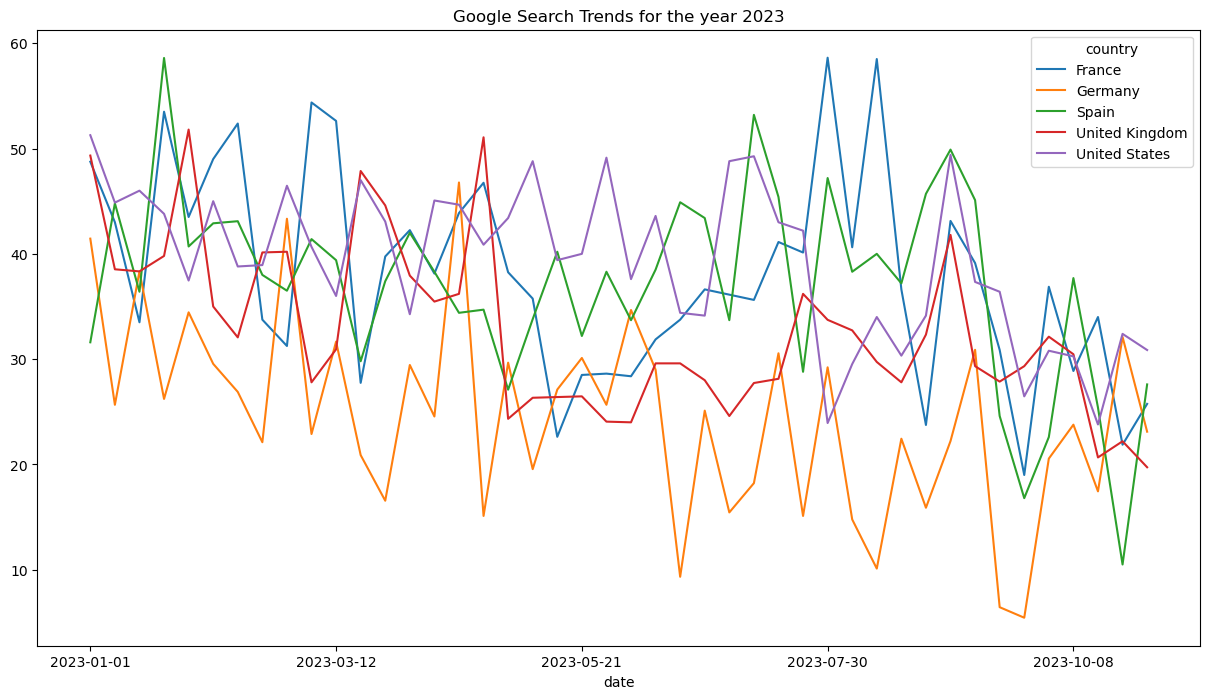

In [14]:
ax = df.reset_index().pivot(index = 'date', columns = 'country', values = 'value').plot(figsize = (15, 8))
ax.set_title("Google Search Trends for the year 2023", fontsize = 12);

##### Comparing the trends for the past 3 years for the same time period (Jan - Sept)

In [17]:
def plot_charts(country):
    df_curr = get_country_df(country, "2023-01")
    df_year1 = get_country_df(country, "2022-01", "2022-09")
    df_year2 = get_country_df(country, "2021-01", "2021-09")

    ax = df_curr.plot(figsize = (14,8))
    df_year1.plot(ax=ax)
    df_year2.plot(ax=ax)
    handles, previous_labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=["2023 trends (Jan-Sept)", "2022 trends (Jan-Sept)", "2021 trends (Jan-Sept)"])
    ax.set_title(f"{con_dict[country]} Trends Analysis");
    ax.set_ylim(0,100);

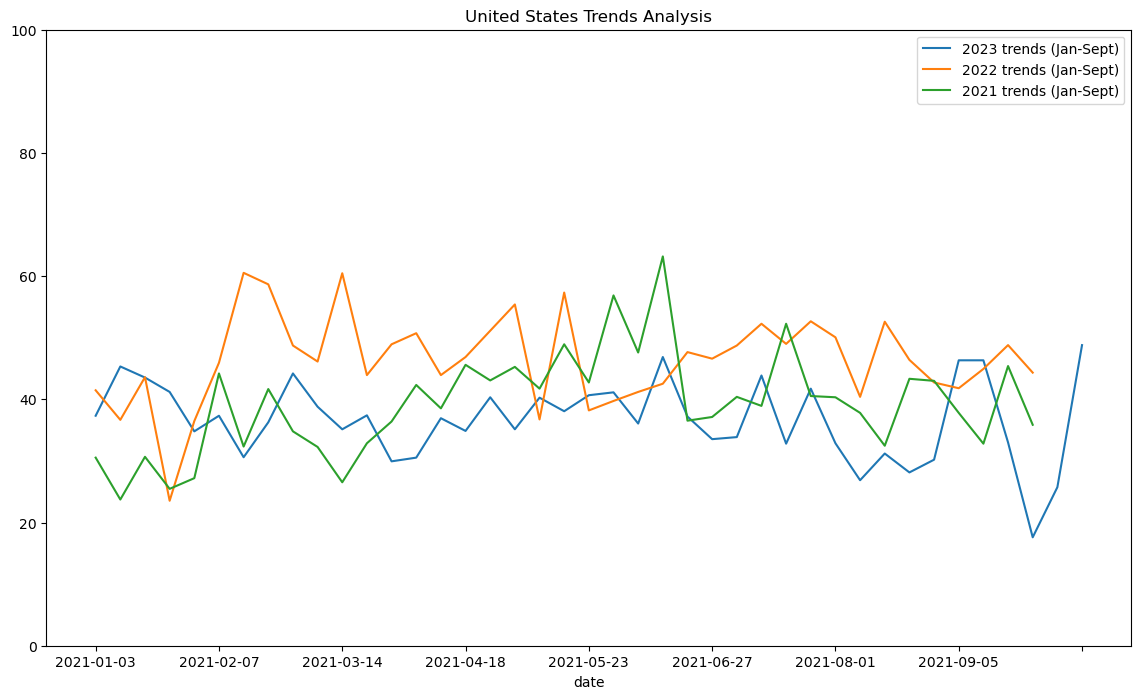

In [18]:
plot_charts("US")

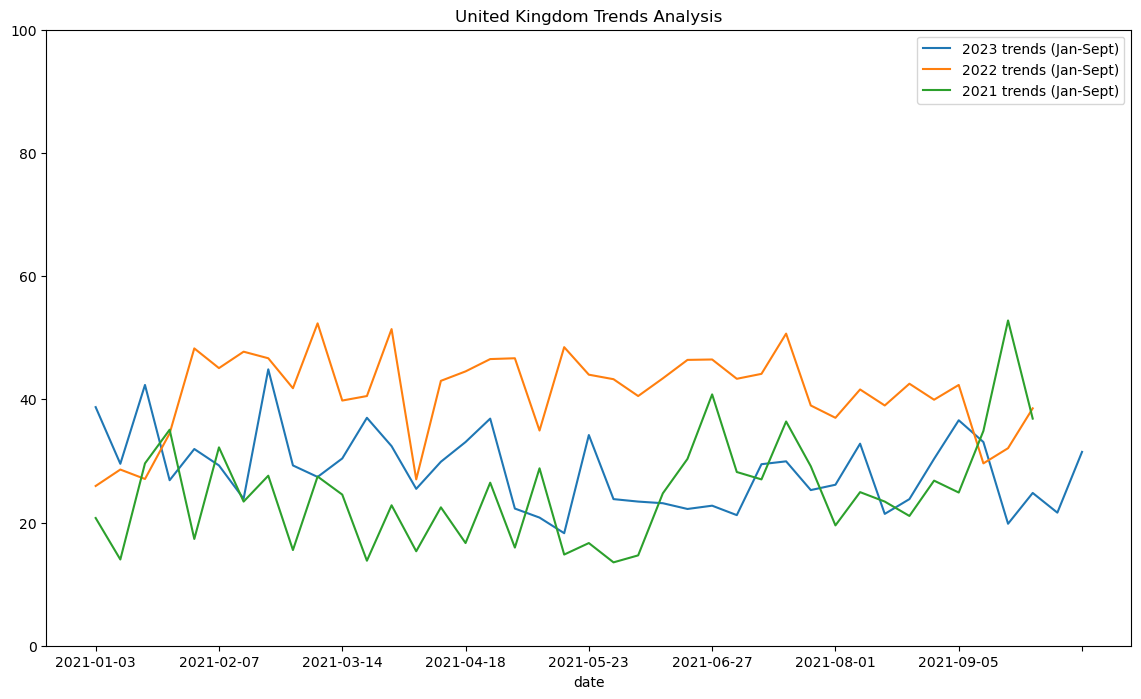

In [19]:
plot_charts("GB")

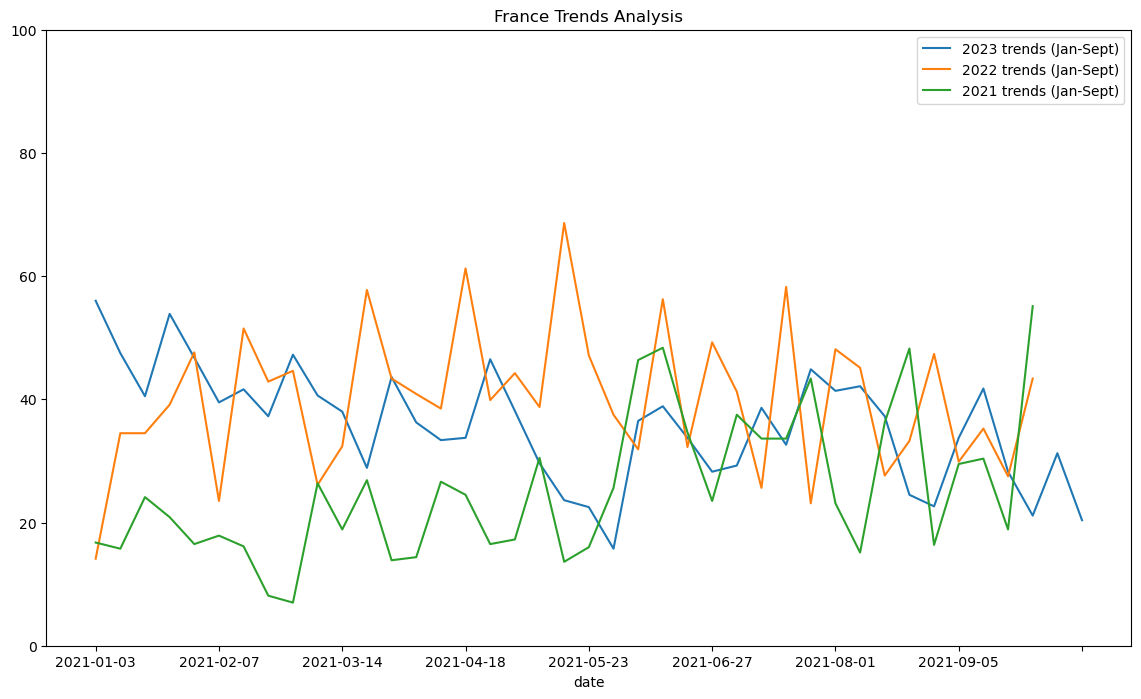

In [20]:
plot_charts("FR")

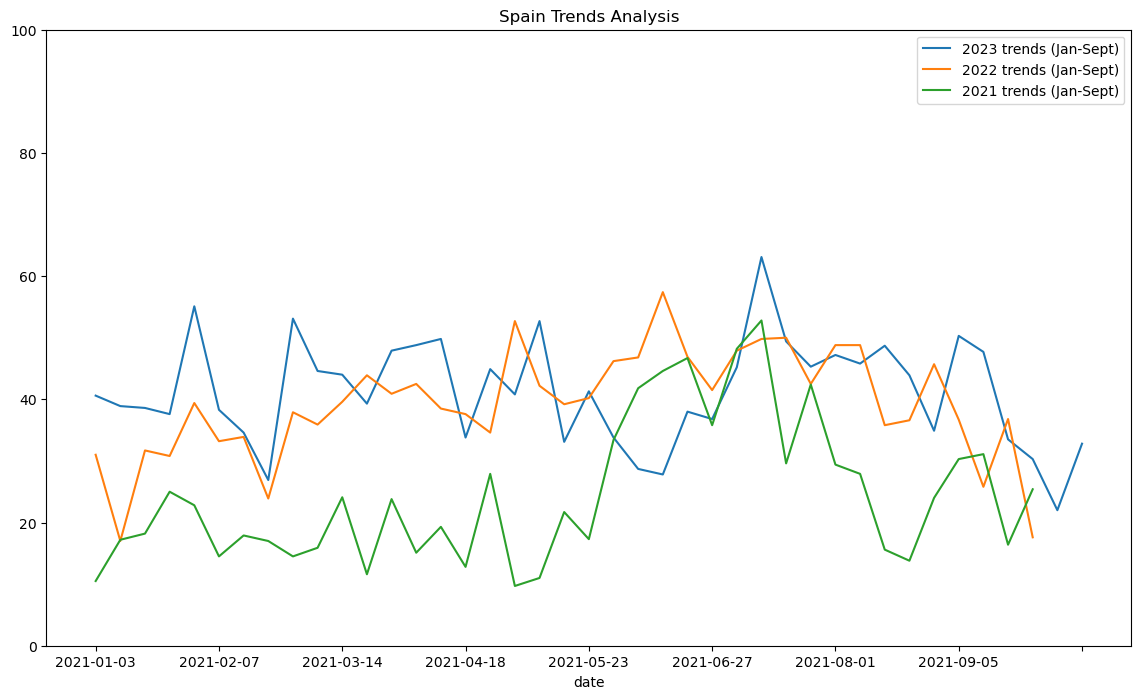

In [21]:
plot_charts("ES")

Overall, as expected, 2021 saw very little search travel terms to Morocco because of COVID restrictions and people not willing to travel internationally unless things were safer. 2022 was one of the busiest year for travel in a decade and the trends in plots above show that. For 2023, the trends have gone down by a little but some months show spikes in search for travel terms. 

### Prediction

To predict if the tourism will be impacted using Google Trends data, we'll collect the data points for set query terms from 2019 to latest available date (removing the time periods when the country was under COVID lockdown).

Specific terms related to flight/hotel cancellation were used but Google Trends did not have enough data to show that. This prediction is solely based on yearly trends and seasonality. 

In [91]:
def predict_trends(country):
    df1 = get_country_df(country, "2019-01", "2020-03")
    df2 = get_country_df(country, "2021-10")

    df = pd.concat([df1, df2])

    ## Removing effects due to seasonality from the time series
    
    result_mul = seasonal_decompose(df.value,model='multiplicative', extrapolate_trend='freq', period = 12)
    deseason = df.value - result_mul.seasonal

    ##spilitting the data into train/test set

    Train = pd.DataFrame(deseason[:-60], columns = ['value'])
    valid = pd.DataFrame(deseason[-60:], columns = ['value'])

    ## Fitting the data to Holt's model
    y_hat_avg = pd.DataFrame(valid).copy() 
    fit1 = Holt(np.asarray(Train.value)).fit(smoothing_level = 0.5) #smoothing_level = 0.3, smoothing_slope = 0.1
    y_hat_avg['Holt_linear'] = fit1.forecast(len(valid))

    rms = sqrt(mean_squared_error(valid.value, y_hat_avg.Holt_linear)) 
    print(f"RMS error for {con_dict[country]}'s data is {rms:.3f}")

    y_hat_avg['date_ordinal'] = pd.to_datetime(y_hat_avg.index).map(dt.toordinal)
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_hat_avg['date_ordinal'], y_hat_avg['Holt_linear'])

    if slope>0:
        print(f"Upward trend: {slope}")
    elif slope<0:
        print(f"Downward trend: {slope}")
    else:
        print("No trend")


    plt.figure(figsize=(20, 8))
    plt.plot(Train['value'], label='training data')
    plt.plot(valid['value'], label='test data') 
    plt.plot(y_hat_avg['Holt_linear'], label='predicted data') 
    plt.legend(loc='best') 
    plt.xticks(rotation = 90, fontsize = 7)
    plt.show()

RMS error for United States's data is 6.418
Downward trend: -0.005496737857977865


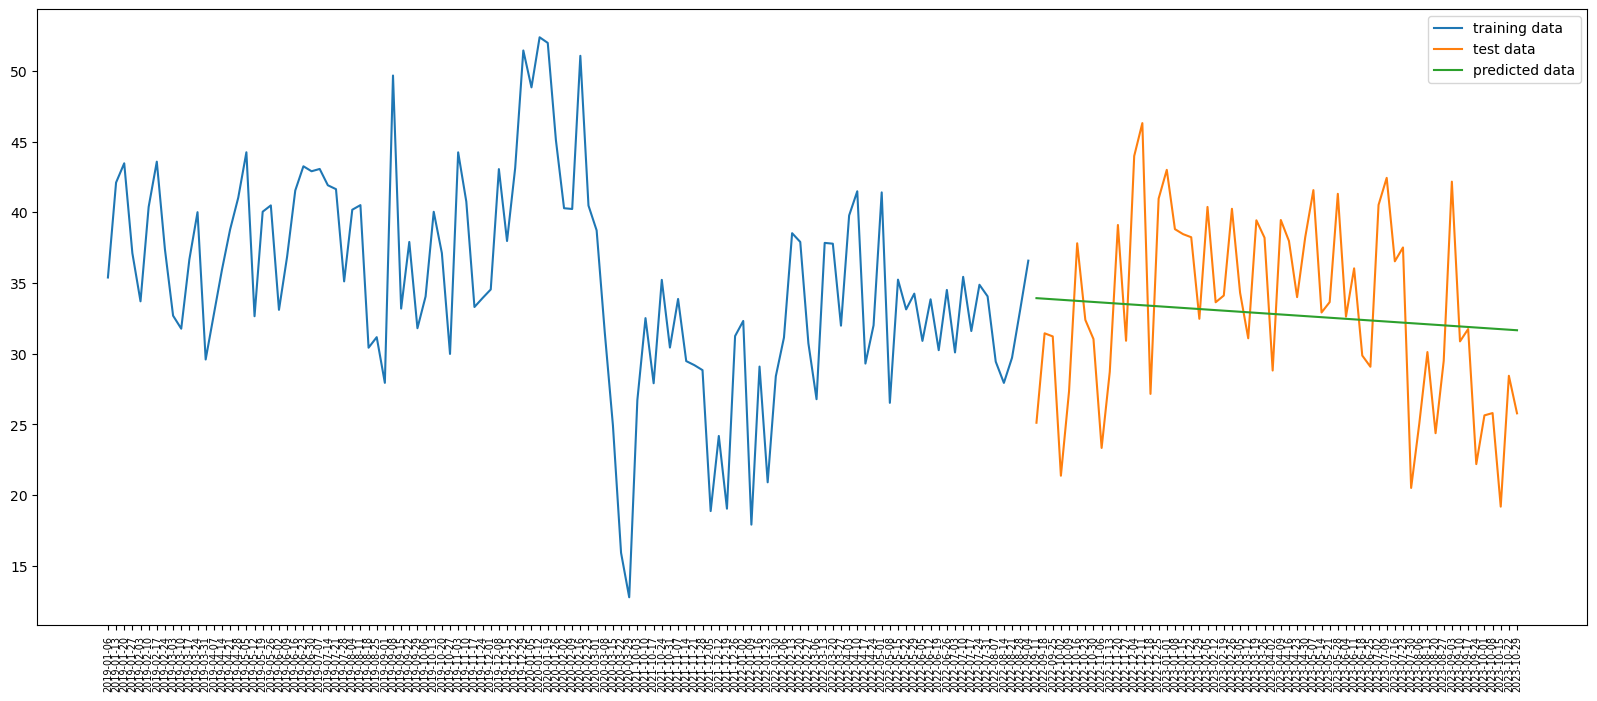

In [16]:
predict_trends("US")

RMS error for Spain's data is 7.062
Downward trend: -0.0047066883396946774


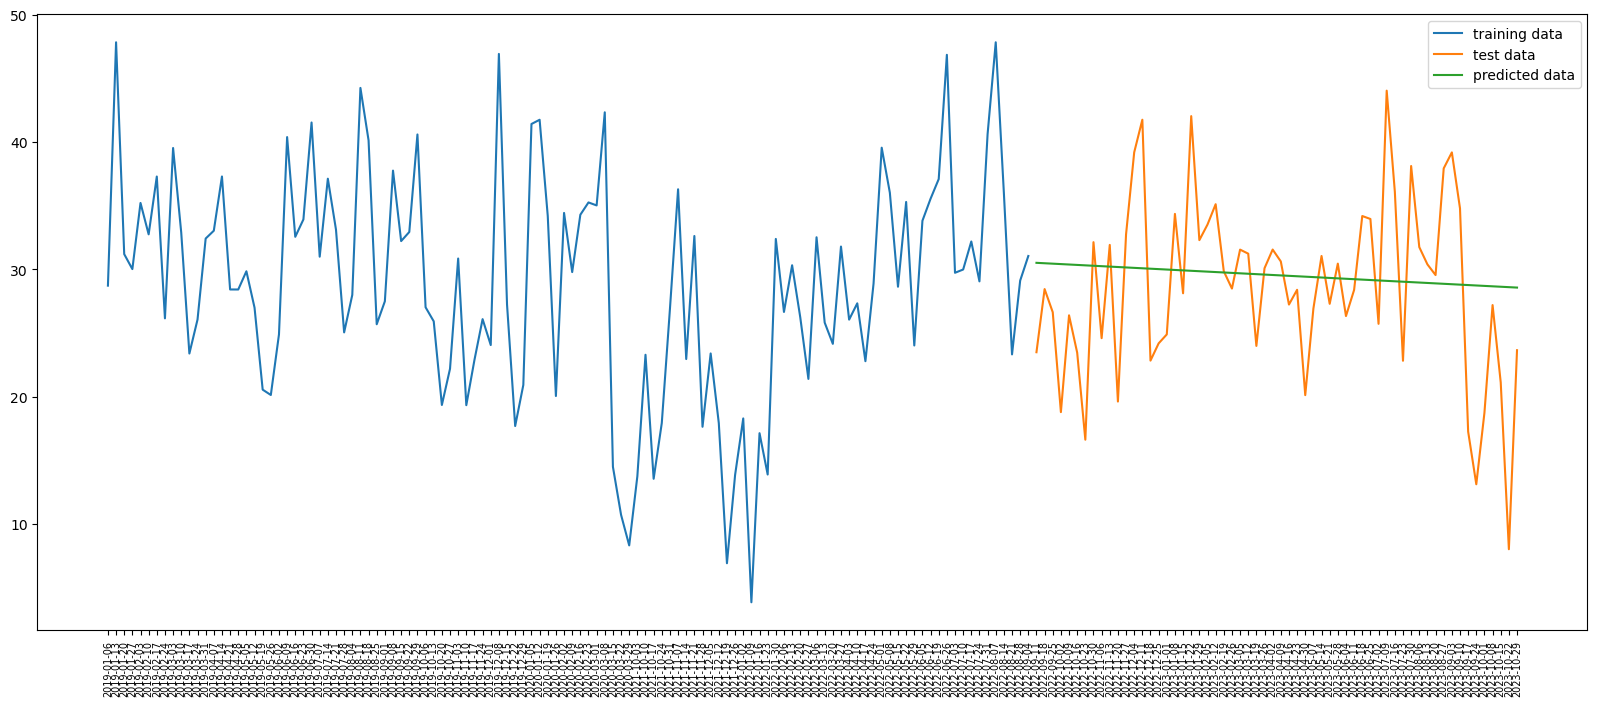

In [17]:
predict_trends("ES")

RMS error for France's data is 15.110
Downward trend: -0.02008914531721257


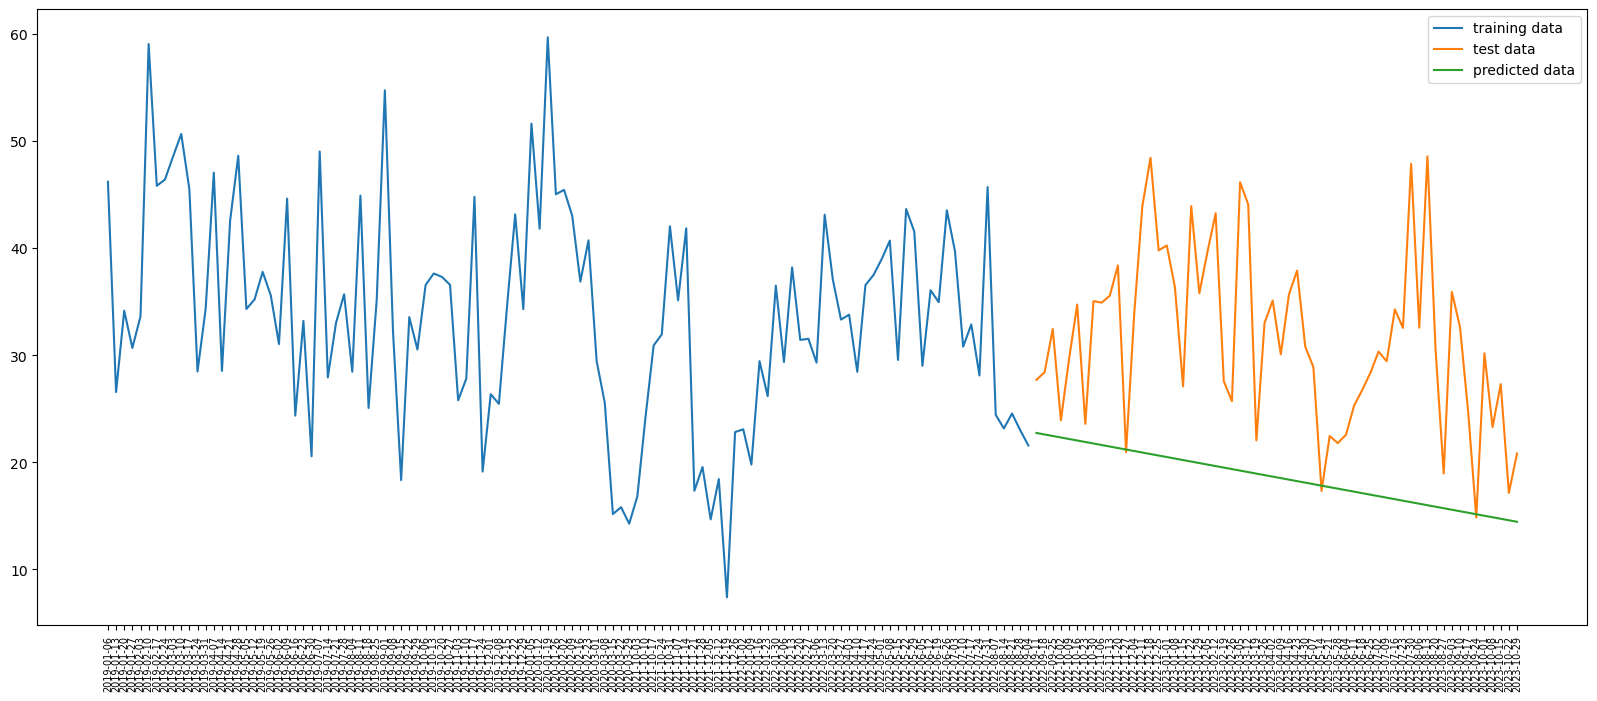

In [18]:
predict_trends("FR")

RMS error for Germany's data is 9.121
Downward trend: -0.011333133009872863


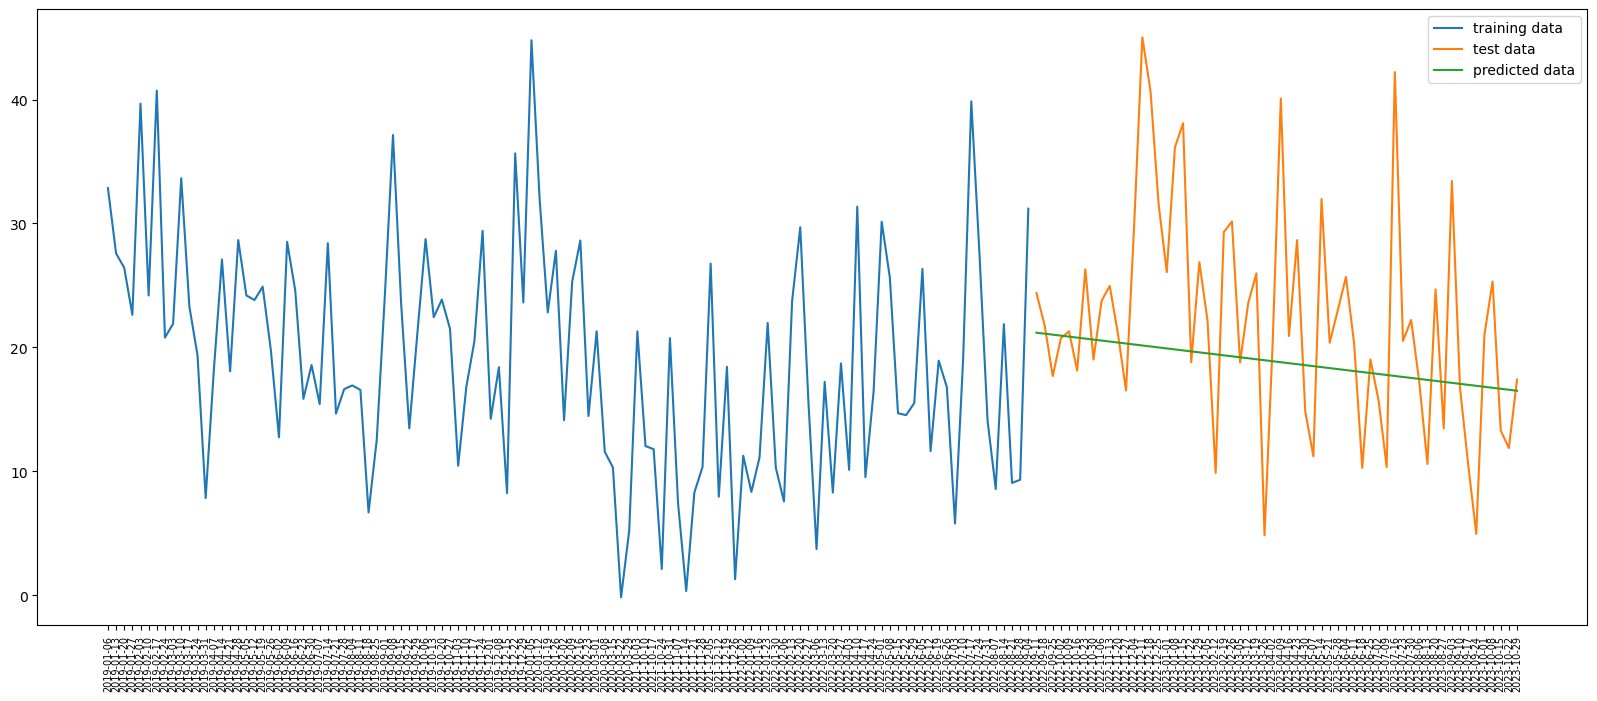

In [102]:
predict_trends("DE")

RMS error for United Kingdom's data is 8.337
Downward trend: -0.020770118936979404


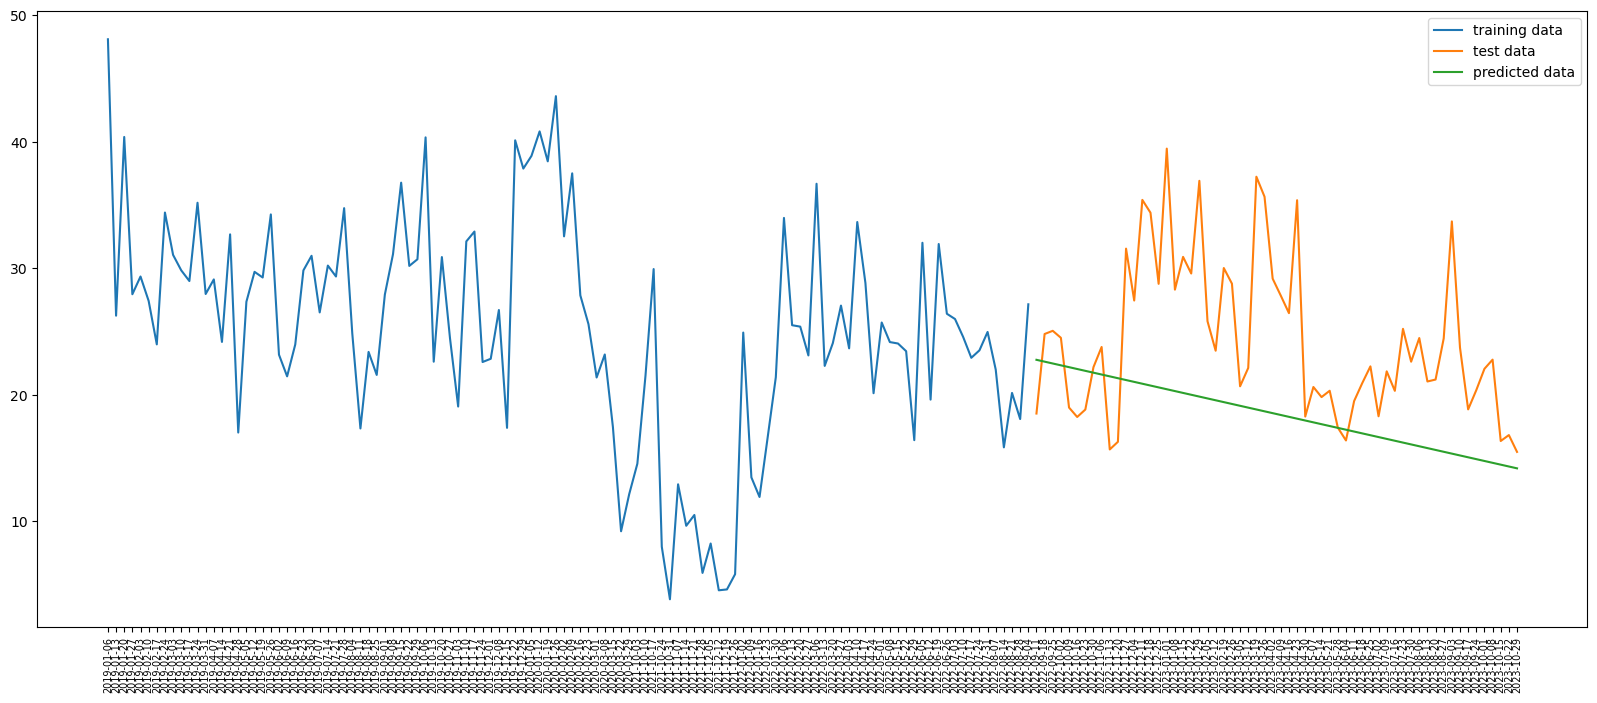

In [20]:
predict_trends("GB")

### Needs Assessment

In [1]:
water_terms = ['water', 'drinking water', 'يشرب الماء', 'ماء', 'eau']

food_terms = ['grocery store', 'souk', 'خضروات', 'restaurant near me', 'store' ]

ph_terms = ['toilette', 'الحمام', 'toilet']

hosp_terms = ['مستشفى', 'hôpital', 'clinique', 'عيادة', 'hospital', 'clinic', 'medical supply', 'medicines', 'الأدوية']

In [65]:
def get_df_ht(terms, country, start_date = None, end_date = None):
    """
    Function to get a dataframe for specified list of terms, country iso2 code and start/end date strings

    Return:
    Pandas Dataframe
    """
    df = pd.DataFrame()
    for term in terms:
        #filters = {
        #    'terms': [term],
        #    'timelineResolution' : 'day' ,
        #    'geoRestriction_region' : country,
        #    #'geoRestriction_country' : country,
        #    'time_startDate' : start_date,
        #    'time_endDate' : end_date
        #}
        filters = {
            'terms': [term],
            'restrictions_geo': country,
            'restrictions_startDate': start_date,
            'restrictions_endDate' : end_date
        }

        #r = google.get('getTimelinesForHealth', filters)
        r = google.get('getGraph', filters)
        df_ = pd.DataFrame(r["lines"][0]["points"])
        df_['query'] = term

        df = pd.concat([df, df_], axis = 0)

    return df

In [86]:
beq_water = get_df_ht(water_terms, 'MA', start_date='2023-07', end_date = "2023-08")
aeq_water = get_df_ht(water_terms, 'MA', start_date='2023-09', end_date = '2023-09')

beq_food = get_df_ht(food_terms, 'MA', start_date='2023-07', end_date = "2023-08")
aeq_food = get_df_ht(food_terms, 'MA', start_date='2023-09', end_date = '2023-09')

beq_ph = get_df_ht(ph_terms, 'MA', start_date='2023-07', end_date = "2023-08")
aeq_ph = get_df_ht(ph_terms, 'MA', start_date='2023-09', end_date = '2023-09')

beq_hosp = get_df_ht(hosp_terms, 'MA', start_date='2023-07', end_date = "2023-08")
aeq_hosp = get_df_ht(hosp_terms, 'MA', start_date='2023-09', end_date = '2023-09')

In [9]:
def get_needs_trends(df):
    df_grp = df.groupby(['date']).mean()

    stat = trenddetector(pd.factorize(df_grp.index)[0], df_grp.value)

    if stat>0:
        print(f"Upward trend: {stat}")
    elif stat<0:
        print(f"Downward trend: {stat}")
    else:
        print("No trend")

Analyzing the trends of search keywords for before and after the earthquake period to see if there was any considerable changes in search for these key topics

In [87]:
print("Trends for before earthquake period of water terms")
get_needs_trends(beq_water)
print("Trends for after earthquake period of water terms")
get_needs_trends(aeq_water)

Trends for before earthquake period of water terms
Downward trend: -0.056548563370350906
Trends for after earthquake period of water terms
Downward trend: -0.2281201334816477


In [88]:
print("Trends for before earthquake period of food terms")
get_needs_trends(beq_food)
print("Trends for after earthquake period of food terms")
get_needs_trends(aeq_food)

Trends for before earthquake period of food terms
Upward trend: 0.02038226184180701
Trends for after earthquake period of food terms
Upward trend: 0.07626251390433746


In [89]:
print("Trends for before earthquake period of personal hygiene terms")
get_needs_trends(beq_ph)
print("Trends for after earthquake period of personal hygiene terms")
get_needs_trends(aeq_ph)

Trends for before earthquake period of personal hygiene terms
Downward trend: -0.017812025215515507
Trends for after earthquake period of personal hygiene terms
Upward trend: 0.1006303299962909


In [90]:
print("Trends for before earthquake period of hospital terms")
get_needs_trends(beq_hosp)
print("Trends for after earthquake period of hospital terms")
get_needs_trends(aeq_hosp)

Trends for before earthquake period of hospital terms
Upward trend: 0.04425865769070405
Trends for after earthquake period of hospital terms
Upward trend: 0.01310097639352356


##### Analyzing data at subnational regions for impacted areas

Béni Mellal-Khénifra Region

In [84]:
#MA-09, MA-07, MA-05
#adm2 = {"Béni Mellal-Khénifra" : "MA-05", "Marrakech-Safi" : "MA-07", "Souss-Massa" : "MA-09"}

needs_terms = {"water" : water_terms, "food" : food_terms, "personal hygiene" : ph_terms, "hospital" : hosp_terms}

#for adm in adm2.keys():
for terms in needs_terms.keys():
    bef = get_df_ht(needs_terms[terms], "MA-05", start_date='2023-07', end_date = "2023-08")
    aft = get_df_ht(needs_terms[terms], "MA-05", start_date='2023-09', end_date = '2023-09')

    print(f"Trends for Béni Mellal-Khénifra before earthquake period of {terms} terms")
    get_needs_trends(bef)
    print(f"Trends for Béni Mellal-Khénifra after earthquake period of {terms} terms")
    get_needs_trends(aft)
    print("============*****=================")

Trends for Béni Mellal-Khénifra before earthquake period of water terms
Downward trend: -0.007680491551459301
Trends for Béni Mellal-Khénifra after earthquake period of water terms
Upward trend: 0.37308120133481615
============*****=================
Trends for Béni Mellal-Khénifra before earthquake period of food terms
Upward trend: 0.05393467804890319
Trends for Béni Mellal-Khénifra after earthquake period of food terms
Downward trend: -0.11884315906562871
============*****=================
Trends for Béni Mellal-Khénifra before earthquake period of personal hygiene terms
Downward trend: -0.1165000461668893
Trends for Béni Mellal-Khénifra after earthquake period of personal hygiene terms
Upward trend: 0.008453837597330177
============*****=================
Trends for Béni Mellal-Khénifra before earthquake period of hospital terms
Upward trend: 0.02309183853340379
Trends for Béni Mellal-Khénifra after earthquake period of hospital terms
Upward trend: 0.17461376838462467
============***

Marrakech-Safi Region

In [83]:
for terms in needs_terms.keys():
    bef = get_df_ht(needs_terms[terms], "MA-07", start_date='2023-07', end_date = "2023-08")
    aft = get_df_ht(needs_terms[terms], "MA-07", start_date='2023-09', end_date = '2023-09')

    print(f"Trends for Marrakech-Safi region before earthquake period of {terms} terms")
    get_needs_trends(bef)
    print(f"Trends for Marrakech-Safi region after earthquake period of {terms} terms")
    get_needs_trends(aft)
    print("============*****=================")

Trends for Marrakech-Safi region before earthquake period of water terms
Downward trend: -0.028395154994837912
Trends for Marrakech-Safi region after earthquake period of water terms
Upward trend: 0.2278086763070074
============*****=================
Trends for Marrakech-Safi region before earthquake period of food terms
Upward trend: 0.02055349903049528
Trends for Marrakech-Safi region after earthquake period of food terms
Downward trend: -0.23172413793103502
============*****=================
Trends for Marrakech-Safi region before earthquake period of personal hygiene terms
Upward trend: 0.07444620718021026
Trends for Marrakech-Safi region after earthquake period of personal hygiene terms
Upward trend: 0.12903225806451554
============*****=================
Trends for Marrakech-Safi region before earthquake period of hospital terms
Downward trend: -0.003676563168895431
Trends for Marrakech-Safi region after earthquake period of hospital terms
Upward trend: 0.15965888023730043
=======

Souss-Massa Region

In [85]:
for terms in needs_terms.keys():
    bef = get_df_ht(needs_terms[terms], "MA-09", start_date='2023-07', end_date = "2023-08")
    aft = get_df_ht(needs_terms[terms], "MA-09", start_date='2023-09', end_date = '2023-09')

    print(f"Trends for Souss-Massa region before earthquake period of {terms} terms")
    get_needs_trends(bef)
    print(f"Trends for Souss-Massa region after earthquake period of {terms} terms")
    get_needs_trends(aft)
    print("============*****=================")

Trends for Souss-Massa region before earthquake period of water terms
Downward trend: -0.016302787640704124
Trends for Souss-Massa region after earthquake period of water terms
Downward trend: -0.13935483870967771
============*****=================
Trends for Souss-Massa region before earthquake period of food terms
Downward trend: -0.075681801012314
Trends for Souss-Massa region after earthquake period of food terms
Downward trend: -0.0017797552836489071
============*****=================
Trends for Souss-Massa region before earthquake period of personal hygiene terms
Downward trend: -0.11513182745335046
Trends for Souss-Massa region after earthquake period of personal hygiene terms
Downward trend: -0.4094178717093071
============*****=================
Trends for Souss-Massa region before earthquake period of hospital terms
Downward trend: -0.0013178548345127812
Trends for Souss-Massa region after earthquake period of hospital terms
Upward trend: 0.35731059201582
============*****====